In [2]:
ff=!pwd
print(ff[0]+"/XGBoost_SHAP_on_clustered_data.ipynb")

/data/hdd-bravo/user01_dir/project_codes/2023/09/clustering_with_NHIS_data/XGBoost_SHAP_on_clustered_data.ipynb


In [40]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,roc_auc_score,roc_curve,accuracy_score,confusion_matrix
import optuna
import xgboost as xgb
import shap
import random

In [41]:
SEED=42

# 클러스터링된 데이터 불러오기

In [42]:
# with open('./result_pickle/NHID_clustering-Copy1/df_integrative.pkl','rb') as f:
# with open('./result_pickle/NHID_clustering-Copy_blink/df_integrative_5.pkl','rb') as f:
with open('./result_pickle/NHID_clustering-Copy_blink/df_integrative_16.pkl','rb') as f:
  df_integrative=pickle.load(f)

In [43]:
df_integrative

,age,alt,ast,creatinine,e_gfr,fasting_glucose,gamma_gtp,hemoglobin,bmi,diastolic_blood_pressure,height,systolic_blood_pressure,waist_circumference,weight,gender,now_drug_treatment,past_disease_history,urine_protein,cluster
0,40.0,19,31,0.6,110,80.0,27.0,12.6,18.6,87,156.5,124,64.0,45.5,1,0,0,0,5
1,52.0,22,26,0.7,118,103.0,28.0,14.6,24.0,75,180.7,118,80.0,78.3,0,0,0,0,3
2,30.0,11,24,0.5,144,82.0,16.0,11.5,23.2,54,160.4,110,77.0,59.7,1,0,0,0,5
3,38.0,35,38,0.5,138,73.0,27.0,13.2,23.4,105,160.8,150,78.0,60.4,1,0,0,0,8
4,46.0,66,52,1.0,80,99.0,43.0,15.8,27.5,98,175.5,146,94.0,84.7,0,1,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23034,58.0,17,13,1.1,54,80.0,20.0,15.3,24.0,100,153.3,171,74.0,56.3,1,1,1,1,8
23035,50.0,11,10,1.1,55,83.0,13.0,13.4,21.0,63,157.6,101,77.0,52.2,1,0,0,0,2
23036,50.0,32,14,1.2,68,91.0,12.0,16.7,26.9,90,174.4,140,85.0,81.9,0,0,0,0,9
23037,56.0,16,20,0.8,78,98.0,13.0,14.8,19.1,55,156.7,125,67.0,47.0,1,0,0,0,2


In [48]:
df_integrative=df_integrative[(df_integrative['cluster']!=13) & (df_integrative['cluster']!=14) & (df_integrative['cluster']!=15)]

In [49]:
df_integrative['cluster'].unique()

array([ 5,  3,  8,  9,  0,  1,  4, 10, 11,  2,  6,  7, 12], dtype=uint16)

In [50]:
vars_numerical=["age","alt","ast","creatinine","e_gfr","fasting_glucose","gamma_gtp","hemoglobin","bmi","diastolic_blood_pressure","height","systolic_blood_pressure","waist_circumference","weight"]
vars_categorical=["urine_protein","gender","now_drug_treatment","past_disease_history"]

In [47]:
for one_cluster in list(df_integrative['cluster'].unique()):
    print('============================================================')
    print('Cluster',one_cluster)
    df_integrative_one_cluster=df_integrative[df_integrative['cluster']==one_cluster]
    print(round(df_integrative_one_cluster[vars_numerical].describe().loc[['mean']].T,2))
    
    for one_var_categorical in vars_categorical:
        selected=df_integrative_one_cluster[one_var_categorical]
        selected_df=selected.value_counts().to_frame()
        selected_df.columns=['Ratio(%)']
        print(round(selected_df/selected.shape[0]*100,2))

Cluster 5
                            mean
age                        40.94
alt                        15.95
ast                        22.26
creatinine                  0.56
e_gfr                     131.27
fasting_glucose            86.74
gamma_gtp                  19.31
hemoglobin                 13.12
bmi                        21.14
diastolic_blood_pressure   69.41
height                    159.99
systolic_blood_pressure   111.67
waist_circumference        70.87
weight                     54.12
               Ratio(%)
urine_protein          
0                 93.49
1                  4.66
2                  1.85
        Ratio(%)
gender          
1          93.88
0           6.12
                    Ratio(%)
now_drug_treatment          
0                       89.6
1                       10.4
                      Ratio(%)
past_disease_history          
0                        87.27
1                        12.73
Cluster 3
                            mean
age                     

# 훈련, 검증, 테스트 데이터로 분할

In [51]:
X=df_integrative.drop('cluster',axis=1)
y=df_integrative['cluster']

X_train_val,X_test,y_train_val,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=SEED)
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,stratify=y,random_state=SEED)

In [52]:
cluster_labels=[str(one) for one in list(y.unique())]
cluster_labels.sort()
cluster_labels

['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

In [53]:
X_train_val

,age,alt,ast,creatinine,e_gfr,fasting_glucose,gamma_gtp,hemoglobin,bmi,diastolic_blood_pressure,height,systolic_blood_pressure,waist_circumference,weight,gender,now_drug_treatment,past_disease_history,urine_protein
1632,44.0,10,22,0.6,115,78.0,17.0,13.1,20.2,89,151.0,130,69.0,46.0,1,1,1,0
14100,54.0,20,23,1.1,74,111.0,48.0,15.5,26.0,73,168.0,130,83.0,73.4,0,0,0,0
20164,42.0,29,26,0.7,131,77.0,55.0,16.9,22.2,87,174.6,117,83.0,67.7,0,0,0,0
19203,66.0,27,30,0.8,71,105.0,8.0,12.1,21.5,74,160.8,124,80.0,55.7,1,1,1,0
6876,48.0,26,30,1.0,84,101.0,20.0,16.2,21.8,81,168.6,112,72.0,61.9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10730,46.0,7,12,0.7,95,97.0,12.0,13.1,21.5,60,163.0,100,68.0,57.0,1,0,0,0
18600,66.0,26,24,0.9,66,84.0,19.0,12.8,25.7,95,157.7,139,74.0,63.8,1,1,1,0
22587,54.0,27,27,0.7,124,124.0,29.0,1.4,22.8,67,162.5,106,78.0,60.2,0,1,1,0
1404,60.0,39,34,0.9,64,106.0,12.0,12.9,26.8,79,166.6,145,83.0,74.5,1,1,1,0


# XGBoost 의 최적 hyperparameter 탐색

In [11]:
def objective(trial):
  params={
    'n_estimators':trial.suggest_int('n_estimators',50,200),
    'max_depth':trial.suggest_int('max_depth',3,10),
    'learning_rate':trial.suggest_loguniform('learning_rate',0.001,0.1),
    'subsample':trial.suggest_float('subsample',0.1,1),
    'colsample_bytree':trial.suggest_float('colsample_bytree',0.1,1),
    'gamma':trial.suggest_float('gamma',0,1),
    'min_child_weight':trial.suggest_float('min_child_weight',1,10),
    'objective':'multi:softmax',
    'num_class':4,
    'eval_metric':'mlogloss'
  }
  
  model=xgb.XGBClassifier(**params,random_state=SEED)
  model.fit(X_train,y_train)
  y_pred=model.predict_proba(X_val)
  auc=roc_auc_score(y_val,y_pred,multi_class='ovr')
  
  return 1-auc

In [12]:
study=optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=100)

[I 2023-11-10 19:39:53,145] A new study created in memory with name: no-name-71600d2d-6cd3-4ce5-9d60-fe0aca120d53
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-11-10 19:40:00,324] Trial 0 finished with value: 0.0055784825514850755 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.012185525404500974, 'subsample': 0.9160403887681464, 'colsample_bytree': 0.38446990457914054, 'gamma': 0.518667221435722, 'min_child_weight': 5.124591418208053}. Best is trial 0 with value: 0.0055784825514850755.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-11-10 19:40:02,924] Trial 1 finished with value: 0.004872690253097778 and parameters: {'n_estimators': 153, 'max_depth': 7, 'learning

In [13]:
print(f'Number of finished trials: {len(study.trials)}')
print(f'Best trial:')
trial=study.best_trial

print(f'Value: {trial.value}')
print(f'Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_params=study.best_params

Number of finished trials: 100
Best trial:
Value: 0.001504612001400507
Params: 
    n_estimators: 191
    max_depth: 6
    learning_rate: 0.09909807969648443
    subsample: 0.555159476329399
    colsample_bytree: 0.6124043088365734
    gamma: 0.38665605006259507
    min_child_weight: 3.196777164358899


# 최적의 hyperparameter로 모델 훈련

In [14]:
final_model=xgb.XGBClassifier(**best_params,random_state=SEED)
final_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6124043088365734, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.38665605006259507,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09909807969648443,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3.196777164358899, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=191,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# 최적의 hyperparameter로 훈련된 최종 모델의 성능 확인

In [15]:
y_pred_proba = final_model.predict_proba(X_test)

y_pred = np.argmax(y_pred_proba, axis=1)

auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

accuracy = accuracy_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

print(f'AUC: {auc}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Sensitivity (Recall) for each class:')
print(sensitivity)
print('Specificity for each class:')
print(specificity)

AUC: 0.9984953879985995
Accuracy: 0.9300087489063867
Confusion Matrix:
[[269   2   1   1   1   4   0   0   3   0   0   0   0]
 [  4 260   5   3   2   1   0   0   0   0   0   0   0]
 [  6   7 234   1   2   4   1   1   0   0   0   0   0]
 [  1   2   1 242   3   0   3   0   0   2   0   0   0]
 [  3   2   2   2 197   5   0   3   3   1   0   0   0]
 [  4   0   1   2   2 197   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0 200   1   0   1   1   0   0]
 [  4   0   6   0   5   0   7 171   3   1   0   0   0]
 [  6   1   0   0   4   0   6   0 144   0   0   0   0]
 [  0   0   0   2   3   0   4   0   1 138   1   2   0]
 [  0   0   0   0   1   0   0   0   0   0  39   0   1]
 [  0   0   0   1   0   0   1   0   0   1   0  26   0]
 [  0   0   0   0   0   0   0   0   0   1   1   0   9]]
Sensitivity (Recall) for each class:
[0.95729537 0.94545455 0.9140625  0.95275591 0.90366972 0.95631068
 0.97087379 0.8680203  0.89440994 0.91390728 0.95121951 0.89655172
 0.81818182]
Specificity for each class:
[

# 최적의 hyperparameter로 훈련된 최종 모델의 ROC 확인

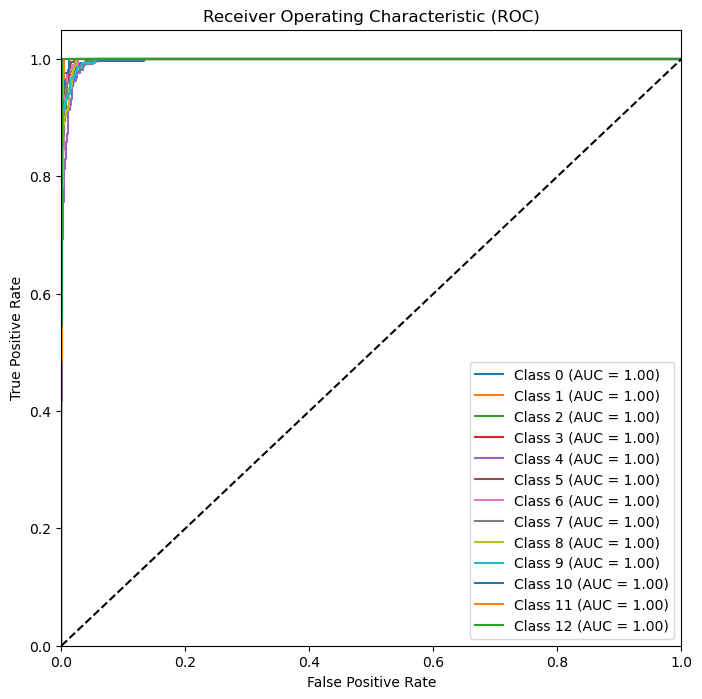

In [16]:
y_pred_proba = final_model.predict_proba(X_test)

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(final_model.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, y_pred_proba[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
for i in range(final_model.n_classes_):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# SHAP 분석 (각 클러스터에서 어떤 변수가 영향을 많이 줬는지)

In [17]:
explainer=shap.Explainer(final_model)
shap_values = explainer.shap_values(X_train)

[19:44:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[19:44:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [18]:
# https://stackoverflow.com/questions/71753428/how-to-get-shap-values-for-each-class-on-a-multiclass-classification-problem-in
# /mnt/external_disk/mycodehtml_snippet/Code_snippet_files/2023/10/How to get SHAP values for each class on a multiclass classification problem in python.mht
def get_ABS_SHAP(df_shap,df):
    shap_v = pd.DataFrame(df_shap)
#     print(shap_v)
#                 0         1         2         3         4         5         6   \
#     0    -1.552953 -0.073505 -0.034340  0.205247 -0.371815 -0.086393  0.078982   
#     1    -0.188535 -0.028801 -0.028754 -0.588657  0.049795 -0.079581 -0.043097   
#     ...        ...       ...       ...       ...       ...       ...       ...   

#                 7         8         9         10        11        12        13  \
#     0     0.069473  0.245509  0.496343  0.150479  0.725901  0.323994  1.650523   
#     1    -0.262241 -1.287559 -0.053987 -0.123038  0.493736 -0.475077 -2.585647   
#     ...        ...       ...       ...       ...       ...       ...       ...   

#                 14        15        16   17  
#     0     0.025980  0.736424  0.801959  0.0  
#     1    -0.058231 -0.219578 -0.202540  0.0  
#     ...        ...       ...       ...  ...  
#     [9143 rows x 18 columns]

    feature_list = df.columns
    shap_v.columns = feature_list
#     print('shap_v',shap_v)
#                age       alt       ast  creatinine     e_gfr  fasting_glucose  \
#     0    -1.552953 -0.073505 -0.034340    0.205247 -0.371815        -0.086393   
#     1    -0.188535 -0.028801 -0.028754   -0.588657  0.049795        -0.079581   
#     ...        ...       ...       ...         ...       ...              ...   

#           gamma_gtp  hemoglobin       bmi  diastolic_blood_pressure    height  \
#     0      0.078982    0.069473  0.245509                  0.496343  0.150479   
#     1     -0.043097   -0.262241 -1.287559                 -0.053987 -0.123038   
#     ...         ...         ...       ...                       ...       ...   

#           systolic_blood_pressure  waist_circumference    weight    gender  \
#     0                    0.725901             0.323994  1.650523  0.025980   
#     1                    0.493736            -0.475077 -2.585647 -0.058231   
#     ...                       ...                  ...       ...       ...   

#           now_drug_treatment  past_disease_history  urine_protein  
#     0               0.736424              0.801959            0.0  
#     1              -0.219578             -0.202540            0.0  
#     ...                  ...                   ...            ...  
#     [9143 rows x 18 columns]

    df_v = df.copy().reset_index().drop('index',axis=1)
#     print('df_v',df_v)
#            age  alt  ast  creatinine  e_gfr  fasting_glucose  gamma_gtp  \
#     0     44.0   10   22         0.6    115             78.0       17.0   
#     1     54.0   20   23         1.1     74            111.0       48.0   
#     ...    ...  ...  ...         ...    ...              ...        ...   

#           hemoglobin   bmi  diastolic_blood_pressure  height  \
#     0           13.1  20.2                        89   151.0   
#     1           15.5  26.0                        73   168.0   
#     ...          ...   ...                       ...     ...   

#           systolic_blood_pressure  waist_circumference  weight  gender  \
#     0                         130                 69.0    46.0       1   
#     1                         130                 83.0    73.4       0   
#     ...                       ...                  ...     ...     ...   

#           now_drug_treatment  past_disease_history  urine_protein  
#     0                      1                     1              0  
#     1                      0                     0              0  
#     ...                  ...                   ...            ...  
#     [9143 rows x 18 columns]
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
#     print('corr_df',corr_df)
#                                0         1
#     0                        age  0.888228
#     1                        alt -0.360713
#     2                        ast  0.360657
#     3                 creatinine -0.858609
#     4                      e_gfr -0.538328
#     5            fasting_glucose -0.684857
#     6                  gamma_gtp -0.714938
#     7                 hemoglobin -0.667921
#     8                        bmi -0.810507
#     9   diastolic_blood_pressure  0.743999
#     10                    height -0.776551
#     11   systolic_blood_pressure  0.722954
#     12       waist_circumference -0.653859
#     13                    weight -0.804663
#     14                    gender  0.914755
#     15        now_drug_treatment  0.951140
#     16      past_disease_history  0.933139
#     17             urine_protein  0.000000
 
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
#     print('corr_df',corr_df)
#                         Variable      Corr  Sign
#     0                        age  0.888228   red
#     1                        alt -0.360713  blue
#     2                        ast  0.360657   red
#     3                 creatinine -0.858609  blue
#     4                      e_gfr -0.538328  blue
#     5            fasting_glucose -0.684857  blue
#     6                  gamma_gtp -0.714938  blue
#     7                 hemoglobin -0.667921  blue
#     8                        bmi -0.810507  blue
#     9   diastolic_blood_pressure  0.743999   red
#     10                    height -0.776551  blue
#     11   systolic_blood_pressure  0.722954   red
#     12       waist_circumference -0.653859  blue
#     13                    weight -0.804663  blue
#     14                    gender  0.914755   red
#     15        now_drug_treatment  0.951140   red
#     16      past_disease_history  0.933139   red
#     17             urine_protein  0.000000  blue

    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
#     print('k2',k2)
#                         Variable  SHAP_abs      Corr  Sign
#     17             urine_protein  0.000000  0.000000  blue
#     1                        alt  0.030435 -0.360713  blue
#     14                    gender  0.041179  0.914755   red
#     2                        ast  0.045031  0.360657   red
#     5            fasting_glucose  0.083954 -0.684857  blue
#     6                  gamma_gtp  0.092996 -0.714938  blue
#     10                    height  0.129191 -0.776551  blue
#     7                 hemoglobin  0.166877 -0.667921  blue
#     3                 creatinine  0.246484 -0.858609  blue
#     4                      e_gfr  0.253772 -0.538328  blue
#     16      past_disease_history  0.391206  0.933139   red
#     15        now_drug_treatment  0.405165  0.951140   red
#     8                        bmi  0.533919 -0.810507  blue
#     9   diastolic_blood_pressure  0.540208  0.743999   red
#     12       waist_circumference  0.540762 -0.653859  blue
#     11   systolic_blood_pressure  0.721732  0.722954   red
#     0                        age  0.797712  0.888228   red
#     13                    weight  1.544352 -0.804663  blue
    
    k2_f = k2[['Variable', 'SHAP_abs', 'Corr']]
    k2_f['SHAP_abs'] = k2_f['SHAP_abs'] * np.sign(k2_f['Corr'])
    k2_f.drop(columns='Corr', inplace=True)
    k2_f.rename(columns={'SHAP_abs': 'SHAP'}, inplace=True)
   
    return k2_f


foo_all = pd.DataFrame()
# Calculate SHAP and abs_SHAP of each variable per cluster
for k,v in list(enumerate(final_model.classes_)):
    foo = get_ABS_SHAP(shap_values[k], X_train)
    foo['class'] = v
    foo_all = pd.concat([foo_all,foo])

    
foo_all['abs_SHAP']=foo_all['SHAP'].abs()

# print('foo_all',foo_all)
# print('foo_all',foo_all.shape)
#            Variable      SHAP  class  abs_SHAP
# 17    urine_protein  0.000000      0  0.000000
# 1               alt -0.030435      0  0.030435
# 14           gender  0.041179      0  0.041179
# 2               ast  0.045031      0  0.045031
# 5   fasting_glucose -0.083954      0  0.083954
# ..              ...       ...    ...       ...
# 10           height  0.116191     12  0.116191
# 0               age  0.129206     12  0.129206
# 1               alt  0.409038     12  0.409038
# 2               ast  0.522712     12  0.522712
# 6         gamma_gtp  1.562771     12  1.562771

# [234 rows x 4 columns]
# foo_all (234, 4)

   
# px.bar(foo_all,x='SHAP', y='Variable', color='class')

invalid value encountered in divide
invalid value encountered in divide

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

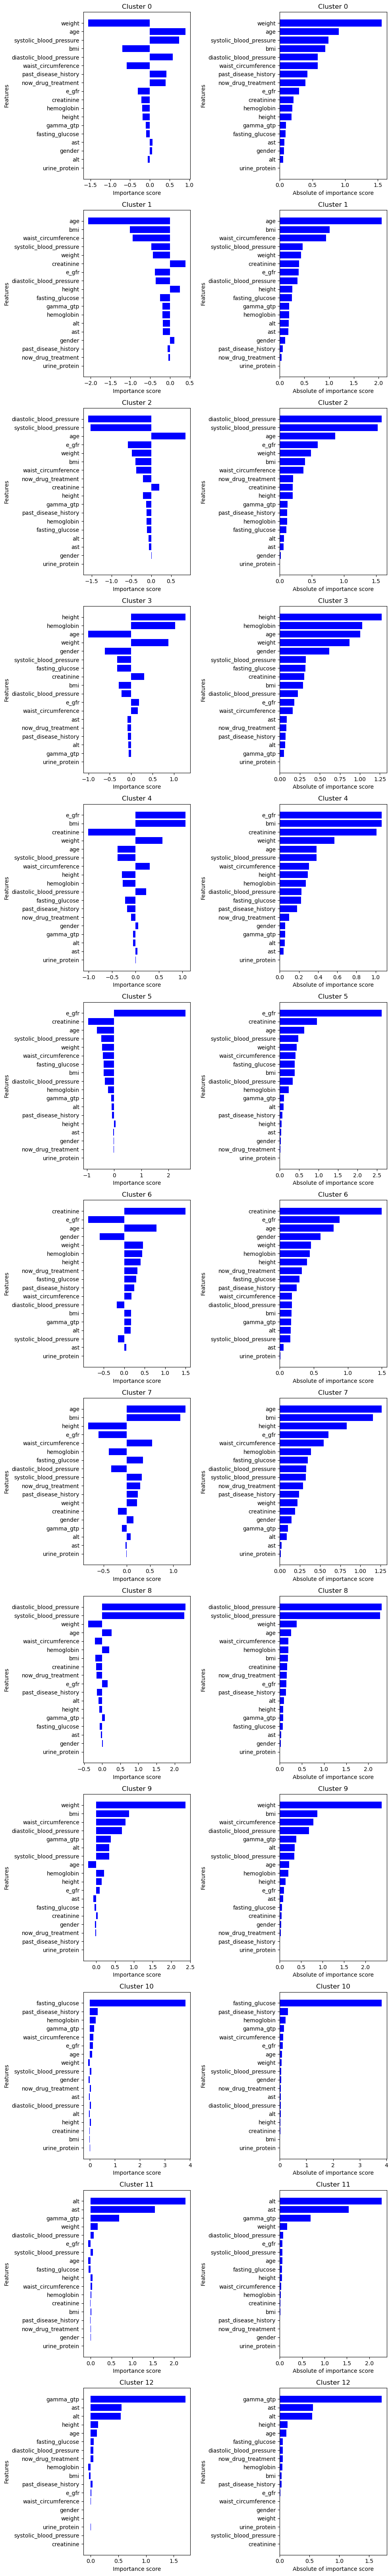

In [19]:
fig,ax=plt.subplots(13,2,figsize=(10,65))

for idx,one_cluster in enumerate(foo_all['class'].unique()):
    selected_class_df=foo_all[foo_all['class']==one_cluster]
    
    ax[idx][0].barh(selected_class_df['Variable'],selected_class_df['SHAP'],color='blue')
#     ax[idx][0].set_xlabel('SHAP')
    ax[idx][0].set_xlabel('Importance score')
    ax[idx][0].set_ylabel('Features')
    ax[idx][0].set_title('Cluster {}'.format(str(one_cluster)))
    
    ax[idx][1].barh(selected_class_df['Variable'],selected_class_df['abs_SHAP'],color='blue')
    # ax[idx][1].set_xlabel('abs SHAP')
    ax[idx][1].set_xlabel('Absolute of importance score')
    ax[idx][1].set_ylabel('Features')
    ax[idx][1].set_title('Cluster {}'.format(str(one_cluster)))

fig.tight_layout()

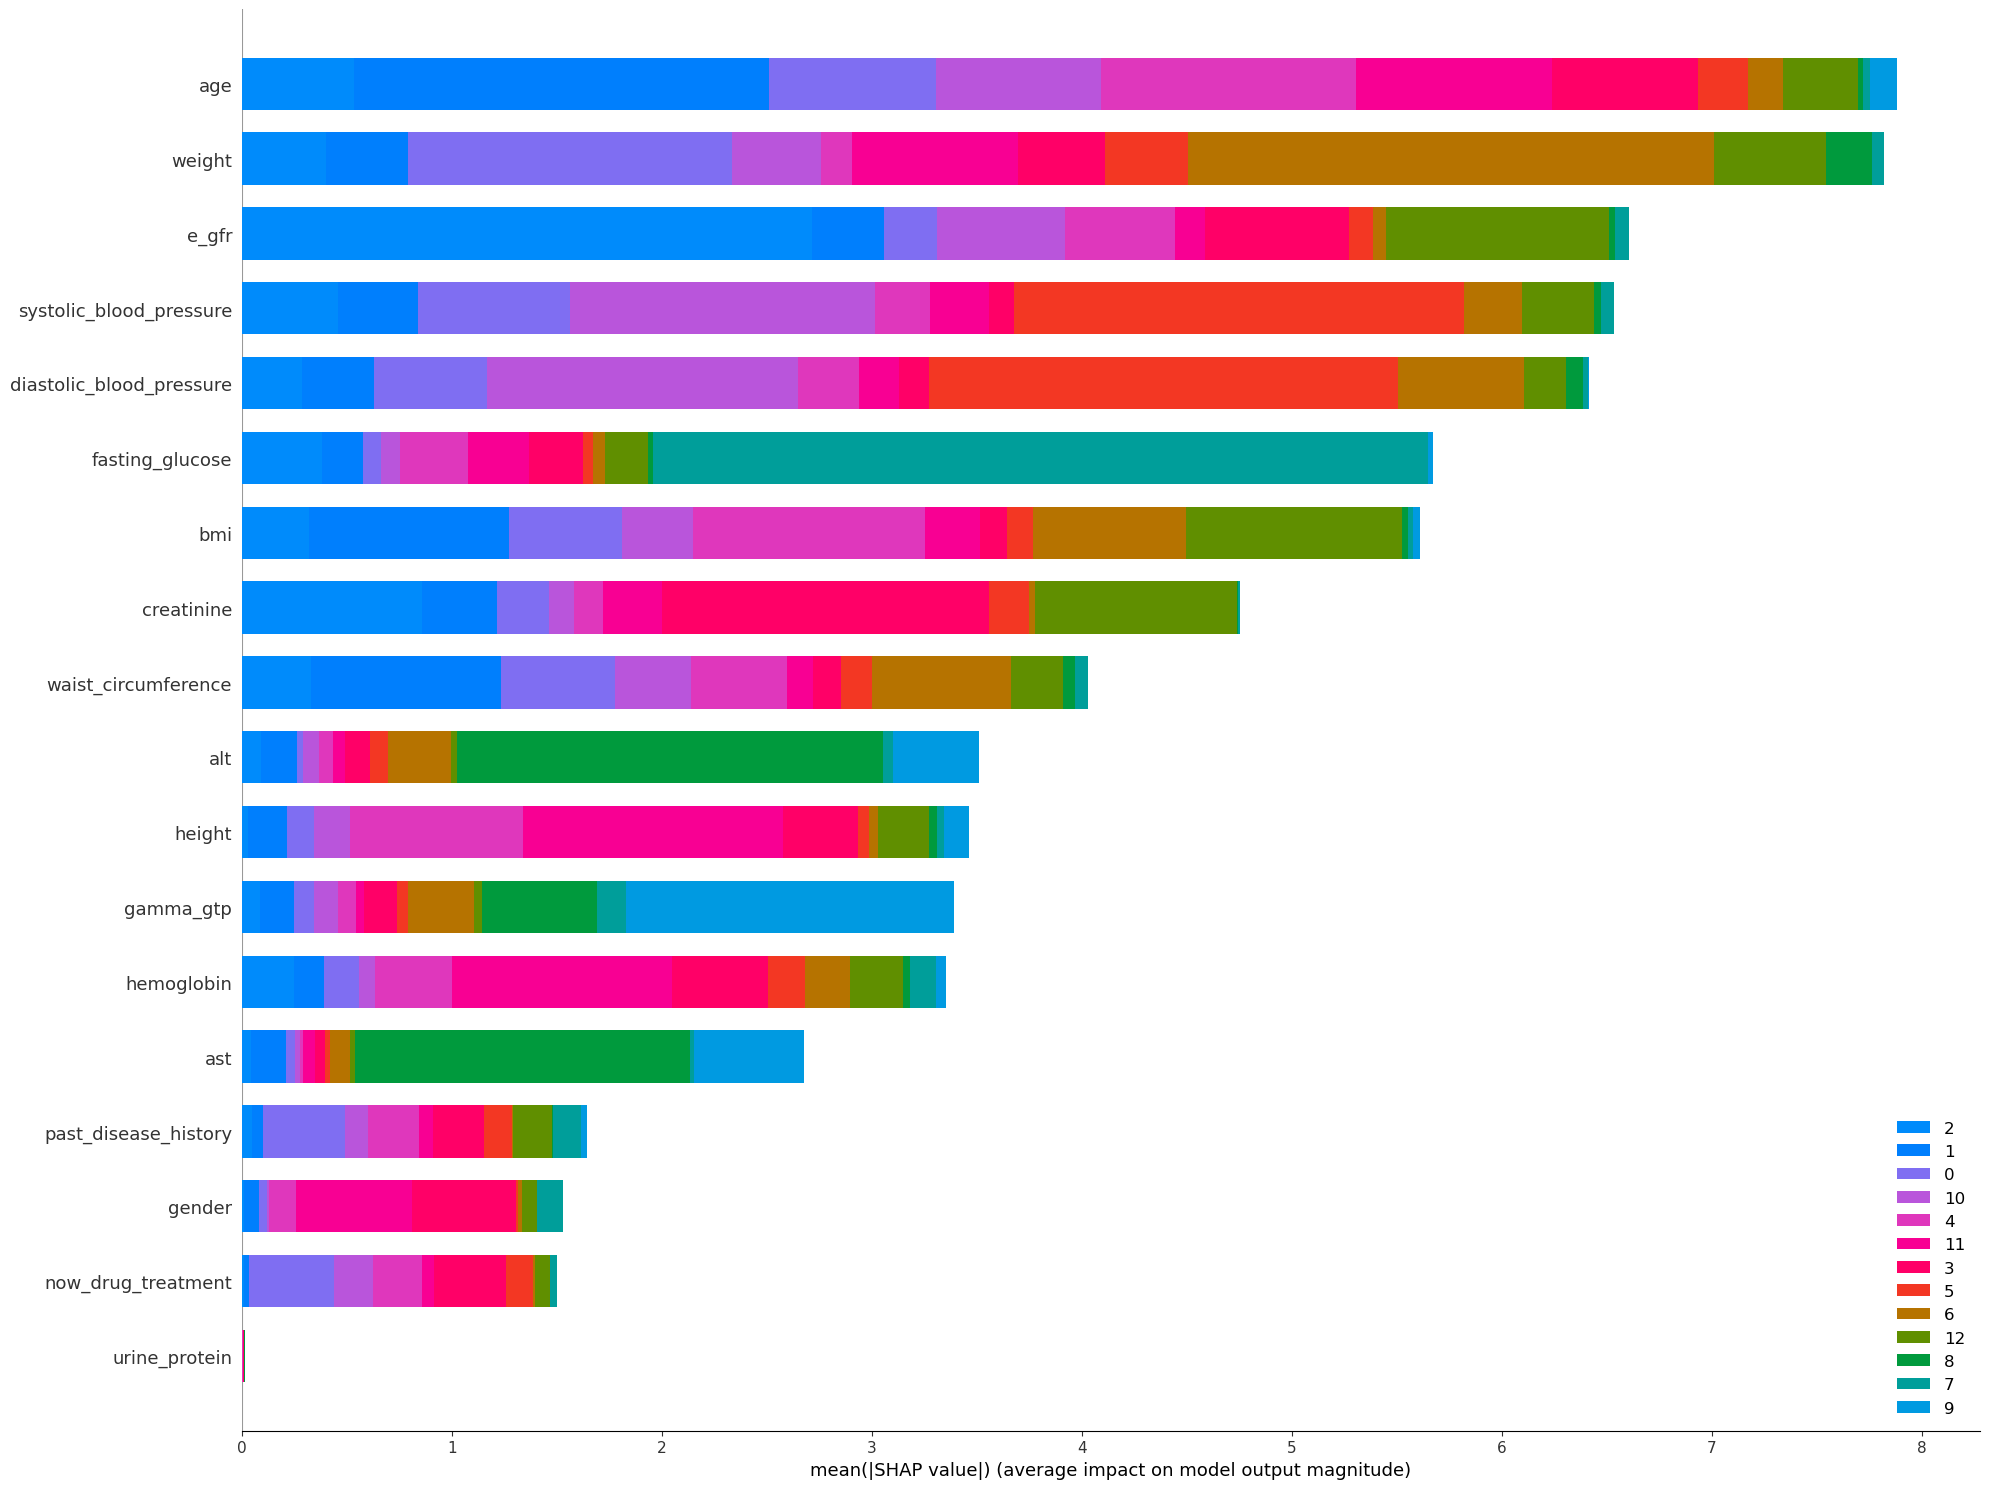

In [62]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 15))

# Generate the summary plot on the specified axes
shap.summary_plot(shap_values, X_train, class_names=cluster_labels, plot_size=[20, 15])


plt.show()